# 자전거 배치 및 운영 전략 최적화 : 수요 예측 모델 개발

[목차]

1. 개요
    - 배경
    - 분석 목적
    - 분석 목표
    - 데이터 설명
    - 라이브러리 호출

2. 데이터 전처리
    - 변수간 상관관계 확인
    - 결측치 처리
    - 중복값 처리
    - 이상치 처리
    - QQ-plot으로 정규성 검증
    

3. EDA
    - 시계열분석
    - 상관관계분석

4. 예측 모델 개발
    - 회귀 모델 실험(선형/릿지/라쏘)

5. 결론

---
---

## 개요

### 1) 배경
- 자전거 대여 시스템의 운영 담당자로, 최적화된 자전거 배치 및 운영 전략을 기획하여 사용자 만족도를 제고시키고 시스템의 효율성을 증가시키는 것이 요구됨

### 2) 분석 목적
- 자전거 대여 패턴을 분석하여 자전거 배치 및 운영 전략을 최적화하고, 대여 수요를 정확히 예측하여 대여 시스템의 효율성을 높이고 사용자 만족도를 증가시키기 위함

### 3) 분석 목표
- 다양한 머신러닝 모델과 전략을 실험하여 가장 정확한 수요 예측 모델을 개발

- 모델의 핵심 평가 지표인 RMSLE (Root Mean Squared Logarithmic Error)를 최대한 낮추는 것

### 4) 데이터 설명

| 컬럼명       | 데이터 타입 | 설명                                           |
|-------------|------------|----------------------------------------------|
| datetime    | datetime   | 자전거 대여 기록의 날짜 및 시간. 예시: 2011-01-01 00:00:00 |
| season      | int        | 계절 (1: 봄, 2: 여름, 3: 가을, 4: 겨울)      |
| holiday     | int        | 공휴일 여부 (0: 평일, 1: 공휴일)              |
| workingday  | int        | 근무일 여부 (0: 주말/공휴일, 1: 근무일)       |
| weather     | int        | 날씨 상황 (1: 맑음, 2: 구름낌/안개, 3: 약간의 비/눈, 4: 폭우/폭설) |
| temp        | float      | 실측 온도 (섭씨)                              |
| atemp       | float      | 체감 온도 (섭씨)                              |
| humidity    | int        | 습도 (%)                                      |
| windspeed   | float      | 풍속 (m/s)                                   |
| casual      | int        | 등록되지 않은 사용자의 대여 수                |
| registered  | int        | 등록된 사용자의 대여 수                      |
| count       | int        | 총 대여 수 (종속 변수)                        |

### 5) 라이브러리 호출 및 데이터 프레임 생성

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from math import sqrt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

In [2]:
# train 데이터 셋 호출
train_df = pd.read_csv('./data/train.csv')
train_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [3]:
# test 데이터 셋 호출
test_df = pd.read_csv('./data/test.csv')
test_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981


---

## 데이터 전처리

### 데이터 정보 확인

> #### train 데이터

In [6]:
train_df.shape

(10886, 12)

In [4]:
# 기술 통계 확인
train_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


- 변수간 스케일 차이 존재 => Feature Scaling 작업 요구됨

In [5]:
# 컬럼별 정보 확인
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


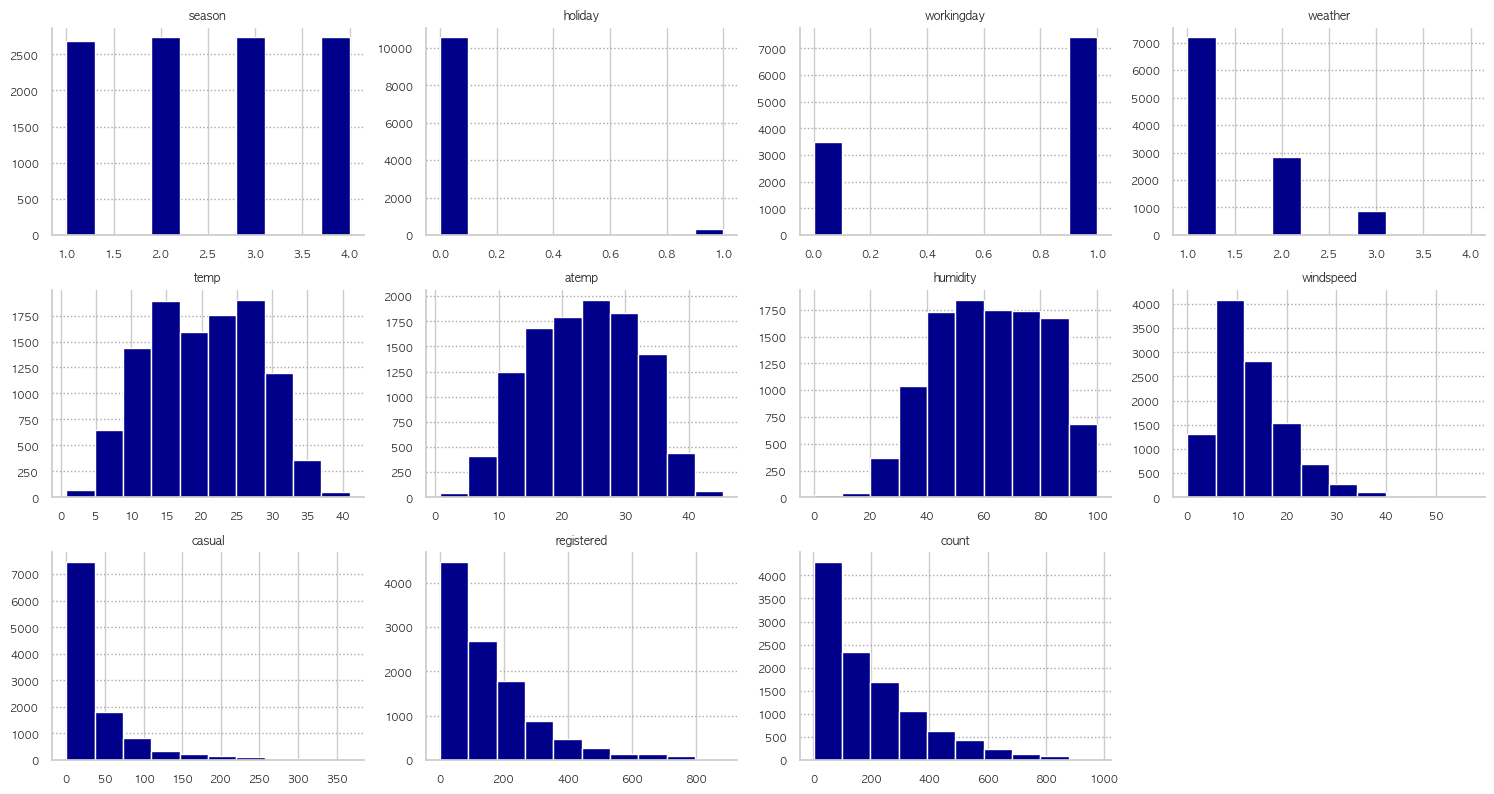

In [36]:
# 히스토그램 시각화
# 변수 선별
numeric_df = train_df.select_dtypes(include=['number'])
cols = numeric_df.columns

# 서브플롯 생성
fig, axes = plt.subplots(3, 4, figsize=(15, 8))
axes = axes.flatten()  

# 각 컬럼에 대해 히스토그램 그리기
for i, column in enumerate(cols):
    axes[i].hist(numeric_df[column].dropna(), color='darkblue', alpha=1)
    axes[i].set_title(column)
    axes[i].grid(axis='y', linestyle=':', color='darkgrey')
    axes[i].spines[['top','right']].set_visible(False)

# 빈 서브플롯 숨기기
for j in range(len(cols), len(axes)):
    axes[j].axis("off")

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

> #### test 데이터

In [9]:
test_df.shape

(6493, 9)

In [7]:
test_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


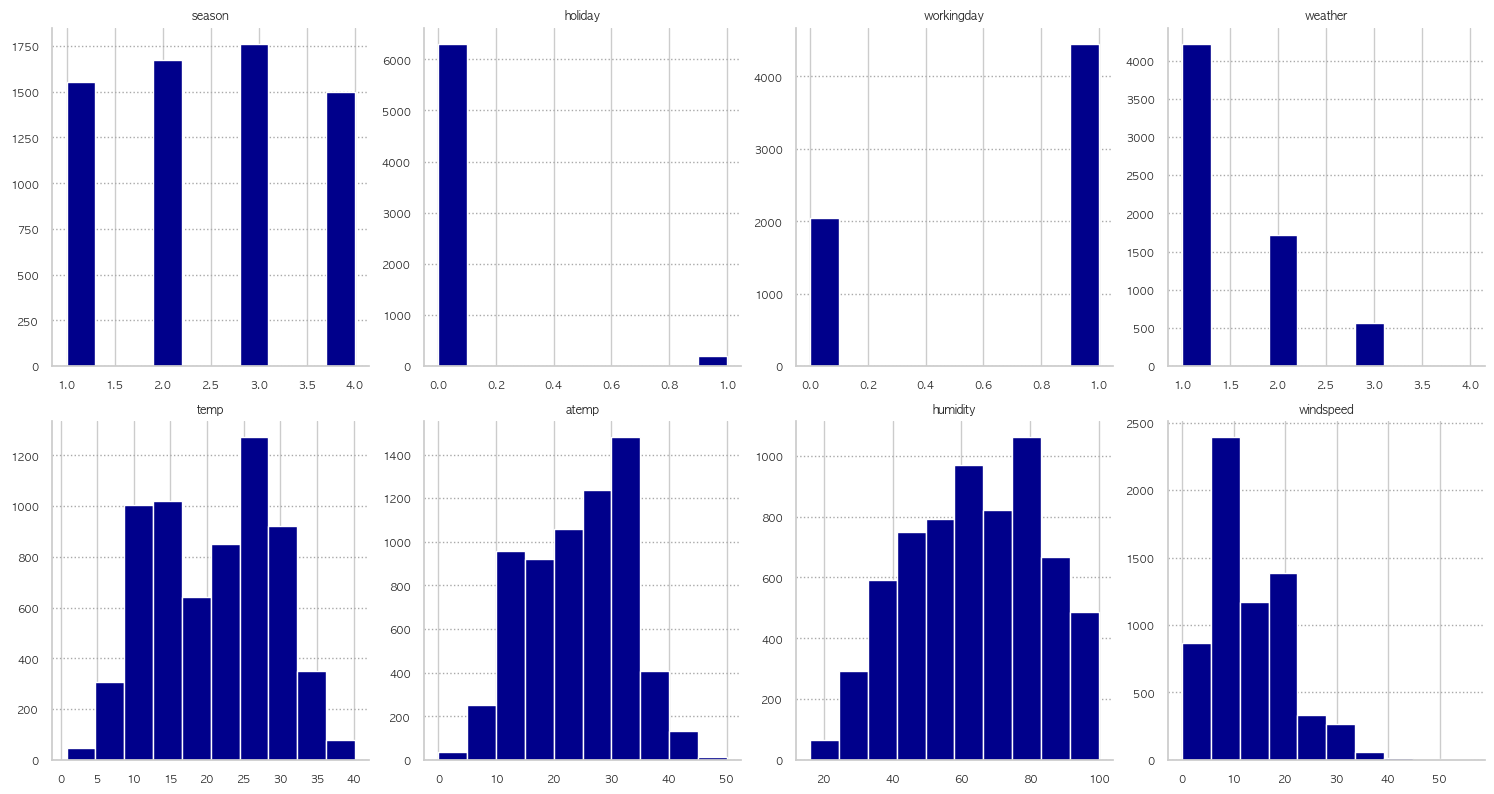

In [38]:
# 히스토그램 시각화
# 변수 선별
numeric_df = test_df.select_dtypes(include=['number'])
cols = numeric_df.columns

# 서브플롯 생성
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()  

# 각 컬럼에 대해 히스토그램 그리기
for i, column in enumerate(cols):
    axes[i].hist(numeric_df[column].dropna(), color='darkblue', alpha=1)
    axes[i].set_title(column)
    axes[i].grid(axis='y', linestyle=':', color='darkgrey')
    axes[i].spines[['top','right']].set_visible(False)

# 빈 서브플롯 숨기기
for j in range(len(cols), len(axes)):
    axes[j].axis("off")

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

- train 데이터에는 `casual`, `registered`, `count` 컬럼 존재
- test 데이터에는 `casual`, `registered`, `count` 컬럼 존재하지 않는다.
- 따라서, 모델 훈련시에도 train데이터의 `casual`, `registered` feature는 제외해야한다.

### 상관관계 확인

- train 데이터 전체 변수간 상관관계 시각화

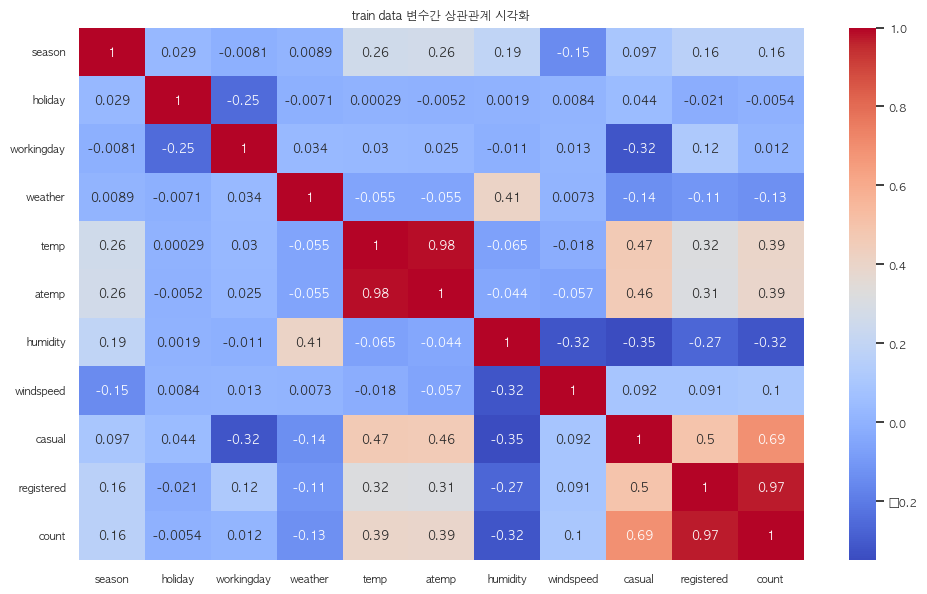

In [17]:
sns.set_theme(style='whitegrid',rc={'figure.figsize':(10,6)}, font='AppleGothic', font_scale=0.7)
sns.heatmap(data=train_df.select_dtypes('number').corr(), cbar=True, annot=True, cmap='coolwarm')

plt.title('train data 변수간 상관관계 시각화')
plt.tight_layout()
plt.show()

- 종속변수(`count`)와의 상관관계만 시각화

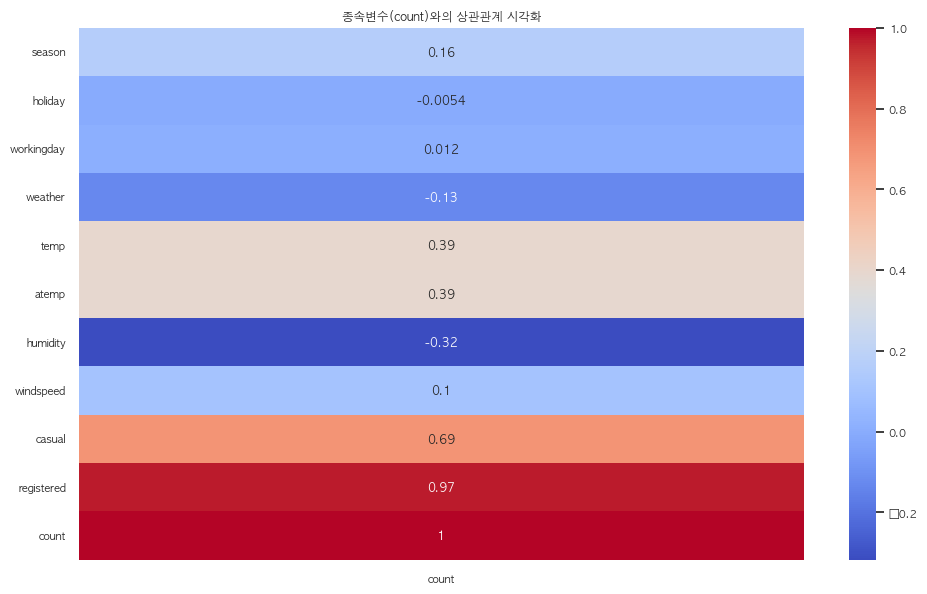

In [18]:
sns.set_theme(rc={'figure.figsize':(10,6)}, font='AppleGothic', font_scale=0.7)
sns.heatmap(data=train_df.select_dtypes('number').corr()[['count']], cbar=True, annot=True, cmap='coolwarm')

plt.title('종속변수(count)와의 상관관계 시각화')
plt.tight_layout()
plt.show()

> 결과 요약
- count = casual + registered 이므로 당연히 `casual`, `registered` 두 변수와의 상관관계는 높다. 따라서 다중공선성 존재할 것이다.

- 양의 상관관계 : `windspeed`, `temp`, `atemp`, `workingday`, `season`
    - 비교적 큰 상관관계 : `temp`, `atemp`
    -  `temp`, `atemp`는 실측온도와 체감온도로, 두 변수는 거의 동일하므로 다중공선성 존재할 것이다.

- 음의 상관관계 : `holiday`, `weather`, `humidity`
    - 비교적 큰 상관관계 : `humidity`

### 결측값 처리

In [19]:
# 컬럼별 결측값 확인
train_df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

### 중복값 처리

In [20]:
# 중복값 확인
train_df.duplicated().sum()

np.int64(0)

### 이상치 처리

In [21]:
numeric_cols = list(train_df.select_dtypes('number').columns)

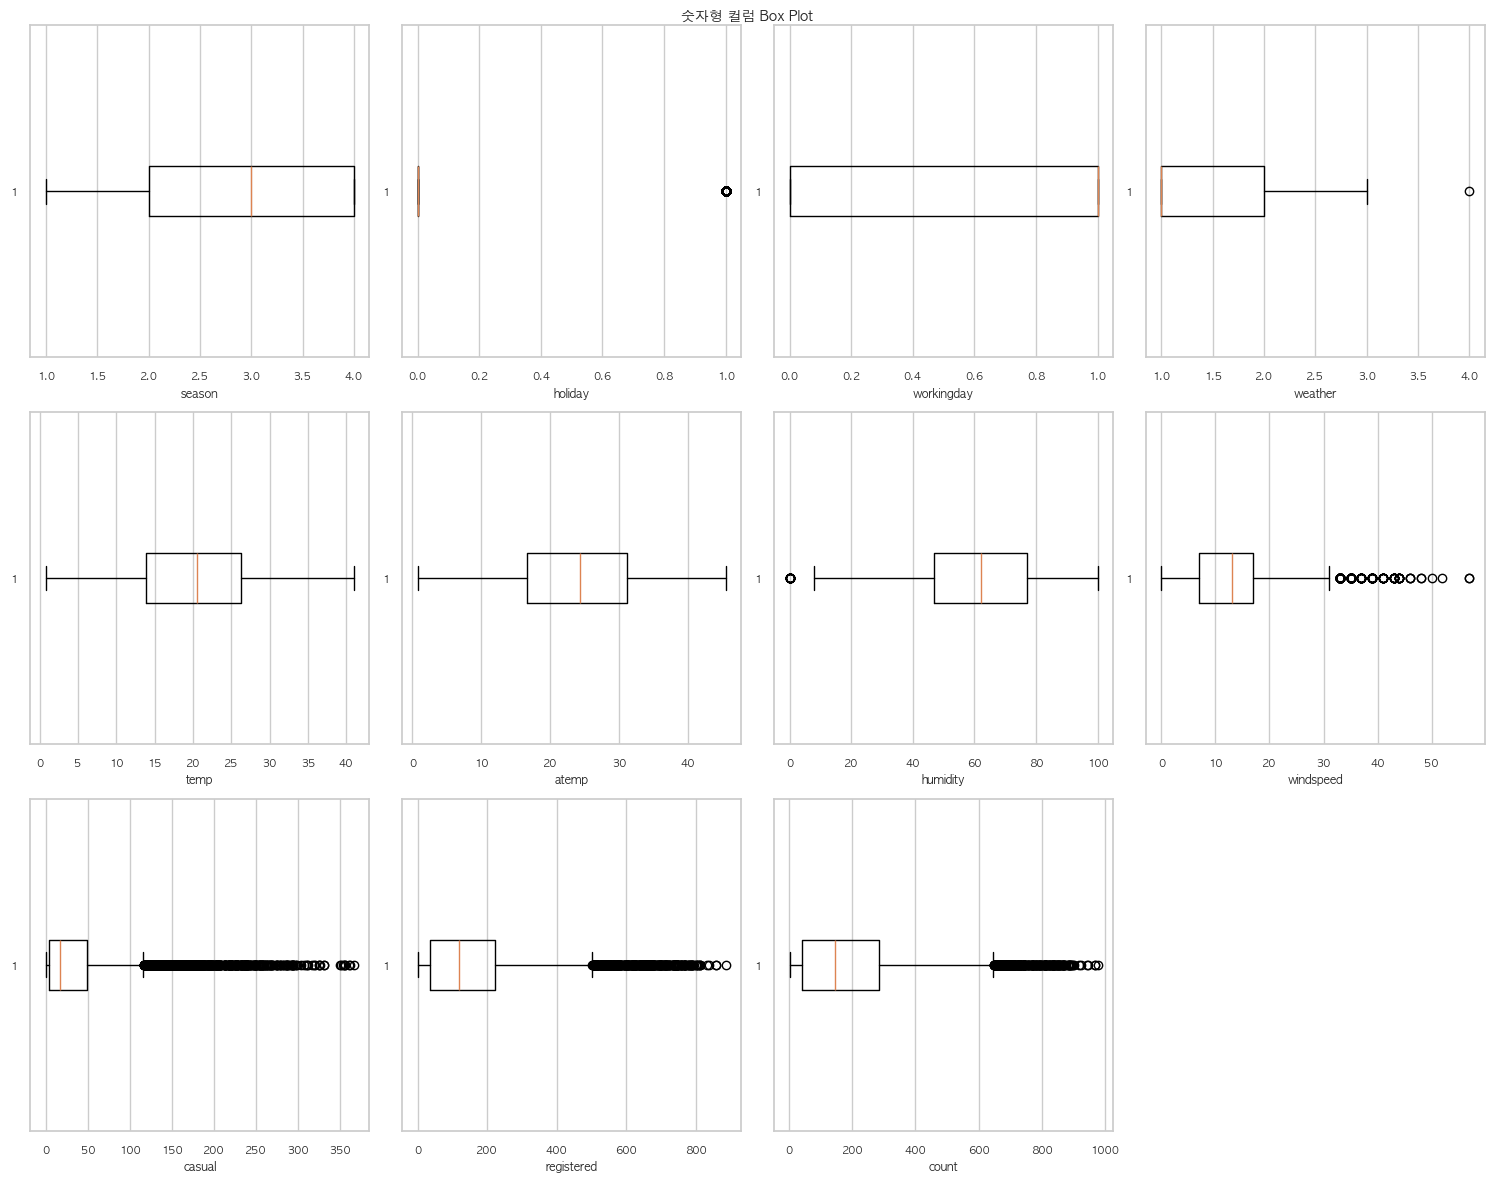

In [29]:
# 컬럼별 이상치 시각화
sns.set_theme(style='whitegrid',rc={'figure.figsize':(10,6)}, font='AppleGothic', font_scale=0.7)

fig, axes = plt.subplots(3,4,figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].boxplot(train_df[col],  vert=False)
    axes[i].set_xlabel(f'{col}')
    axes[i].set_xlabel(f'{col}')
    axes[i].grid(axis='y')

# 빈 서브플롯 숨기기
for j in range(len(numeric_cols), len(axes)):
    axes[j].axis("off")

fig.suptitle('숫자형 컬럼 Box Plot')

fig.tight_layout()
fig.show()

> 결과 요약
- `season`, `workingday`, `hoilday`는 범주형 변수이므로 이상치를 처리하지 않는다.
- 대여 수를 나타내는 `casual`, `registered`, `count` 컬럼에서 이상치가 주로 발생
- max값과 min값 확인하여 이상치 처리 판단

In [32]:
train_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


- 추가로 대여수 관련하여 시계열분석을 통해 이상치가 납득이 되는 합리적인 값인지 판단

In [33]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
# 시간단위로 집계된 datetime 컬럼을 

In [ ]:
# 이상치 탐색하는 함수 생성
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)  # 1사분위수
    Q3 = df[column].quantile(0.75)  # 3사분위수
    IQR = Q3 - Q1  # 사분위 범위
    lower_bound = Q1 - 1.5 * IQR  # 하한
    upper_bound = Q3 + 1.5 * IQR  # 상한
    
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df


---

## EDA

### Feature Engineering